In [70]:
from CommonFunctions import CVE_Functions
from CommonFunctions import LangevinFunctions
from CommonFunctions import StatsFunctions
SF_F = StatsFunctions.Statistics_Functions()
CVE_F = CVE_Functions.CVE()
LF_F = LangevinFunctions.LF()
import numpy as np

In [159]:
DT = 1
NAxes = 1
deltaT = 0.1
NSteps = 100000
coords = LF_F.BrownianTrans(DT, 3, deltaT, NSteps)
X = coords[0]
Y = coords[1]
Z = coords[2]

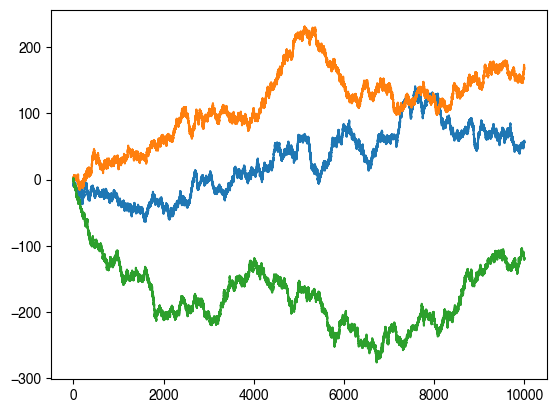

In [160]:
import matplotlib.pyplot as plt
t = np.linspace(0, NSteps*deltaT, NSteps)
plt.plot(t, X)
plt.plot(t, Y)
plt.plot(t, Z)

In [161]:
DX, sigmaX, varDX = CVE_F.Eq14(X, t)
DY, sigmaY, varDY = CVE_F.Eq14(Y, t)
DZ, sigmaZ, varDZ = CVE_F.Eq14(Z, t)

In [162]:
Px = CVE_F.periodogram(X, deltaT, len(X))

In [163]:
bw = np.linspace(0, np.max(epsilon_k), int(np.around(np.max(epsilon_k)*2)))

In [164]:
epsilon_k = Px/np.mean(Px)

In [165]:
pdf, eps_vals = np.histogram(epsilon_k, bins=np.linspace(0, np.max(epsilon_k), int(np.around(np.max(epsilon_k)*2))), density=False)

In [166]:
eps_vals

array([ 0.        ,  0.51845477,  1.03690955,  1.55536432,  2.0738191 ,
        2.59227387,  3.11072865,  3.62918342,  4.1476382 ,  4.66609297,
        5.18454775,  5.70300252,  6.2214573 ,  6.73991207,  7.25836685,
        7.77682162,  8.2952764 ,  8.81373117,  9.33218595,  9.85064072,
       10.3690955 , 10.88755027, 11.40600505, 11.92445982, 12.4429146 ,
       12.96136937, 13.47982415, 13.99827892, 14.51673369, 15.03518847,
       15.55364324, 16.07209802, 16.59055279, 17.10900757, 17.62746234,
       18.14591712, 18.66437189, 19.18282667])

In [167]:
xcenters = (eps_vals[:-1] + eps_vals[1:]) / 2

In [168]:
xcenters

array([ 0.25922739,  0.77768216,  1.29613694,  1.81459171,  2.33304649,
        2.85150126,  3.36995604,  3.88841081,  4.40686559,  4.92532036,
        5.44377514,  5.96222991,  6.48068469,  6.99913946,  7.51759423,
        8.03604901,  8.55450378,  9.07295856,  9.59141333, 10.10986811,
       10.62832288, 11.14677766, 11.66523243, 12.18368721, 12.70214198,
       13.22059676, 13.73905153, 14.25750631, 14.77596108, 15.29441586,
       15.81287063, 16.33132541, 16.84978018, 17.36823496, 17.88668973,
       18.40514451, 18.92359928])

In [205]:
x = eps_vals[1:]
gamma = np.multiply(len(epsilon_k), SF_F.gamma_pdf(x, 0.5, 2.))

<BarContainer object of 37 artists>

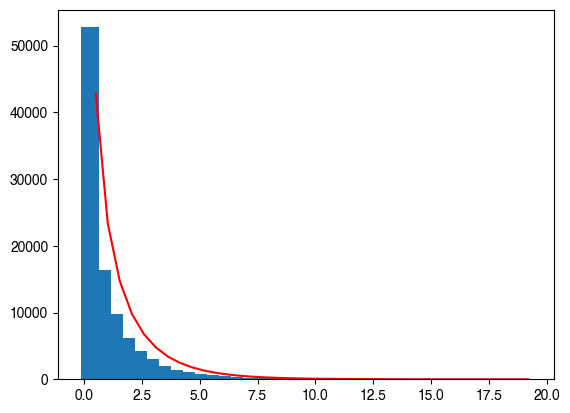

In [206]:
plt.plot(x, gamma, color='red')
plt.bar(xcenters, pdf)

In [207]:
chi = np.divide((np.square(pdf - gamma)), gamma)

In [208]:
np.sum(chi)

11056.602952839705